In [1]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

Torch version: 1.8.1


In [2]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [3]:
! wget {MODELS["ViT-B/32"]} -O model.pt

--2021-05-20 14:04:00--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.36, 13.107.213.36, 2620:1ec:bdf::36, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

100%[======================================>] 353,976,522 4.38MB/s   in 66s    

2021-05-20 14:05:06 (5.12 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [4]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [6]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-05-20 14:06:22--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.40, 13.107.213.40, 2620:1ec:bdf::40, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

100%[======================================>] 1,356,917   6.46MB/s   in 0.2s   

2021-05-20 14:06:22 (6.46 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [7]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
# descriptions = {
#     "page": "a page of text about segmentation",
#     "chelsea": "a facial photo of a tabby cat",
#     "astronaut": "a portrait of an astronaut with the American flag",
#     "rocket": "a rocket standing on a launchpad",
#     "motorcycle_right": "a red motorcycle standing in a garage",
#     "camera": "a person looking at a camera on a tripod",
#     "horse": "a black-and-white silhouette of a horse", 
#     "coffee": "a cup of coffee on a saucer"
# }

In [36]:
# Load Random ImageNet Image

imagenet_path = '/om5/user/xboix/data/ImageNet/raw-data/validation/'

categories = ["%s/%s"%(imagenet_path, i) for i in os.listdir(imagenet_path)]

category_num = 312

import random
random_img = random.sample(os.listdir(categories[category_num]), 8)

imagenet_files = ["%s/%s"%(categories[category_num], i) for i in random_img]

In [46]:
imagenet_files = ['/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00013877.JPEG',
 '/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00020697.JPEG',
 '/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00003946.JPEG',
 '/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00030803.JPEG',
 '/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00012505.JPEG',
 '/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00003946.JPEG',
 '/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00013920.JPEG',
 '/om5/user/xboix/data/ImageNet/raw-data/validation//n03895866/ILSVRC2012_val_00010334.JPEG']

In [47]:
# imagenet_files

In [48]:
# imagenet_files

In [49]:
# Image.open(imagenet_files[2])

In [50]:
images = []

for filename in imagenet_files:
    image = preprocess(Image.open(filename).convert("RGB"))
    images.append(image)

In [57]:
image.shape

torch.Size([3, 224, 224])

In [51]:
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [52]:
tokenizer = SimpleTokenizer()
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

In [53]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [54]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()
text_input.shape

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

Files already downloaded and verified


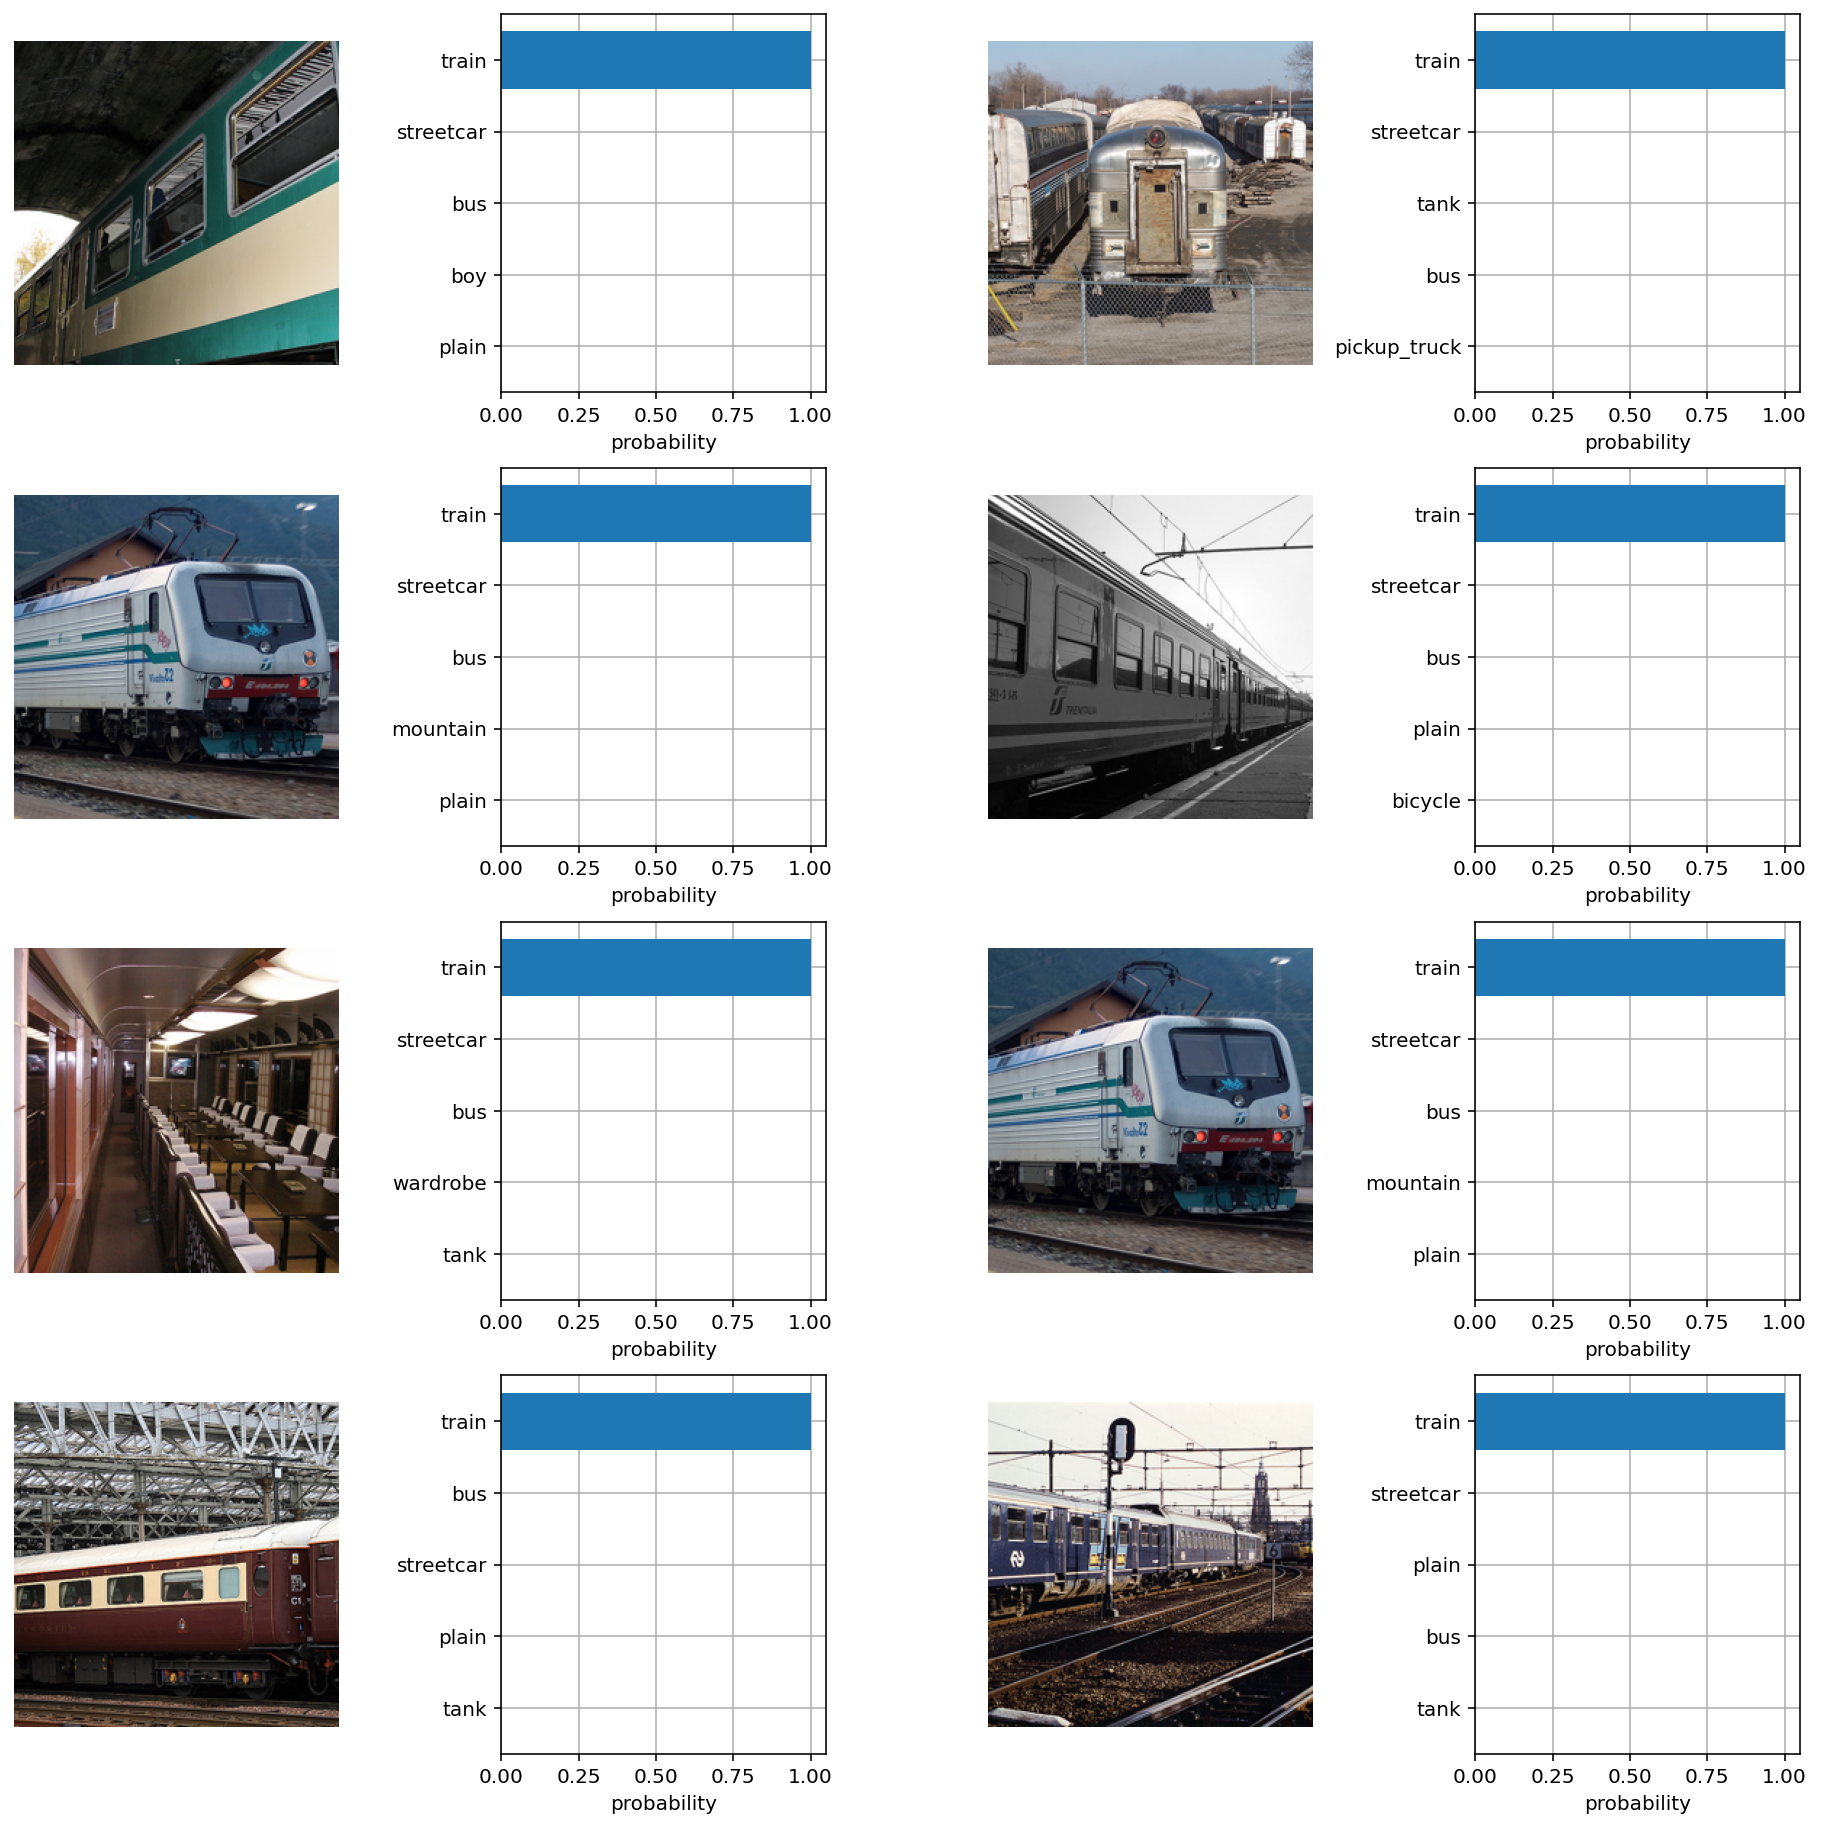

In [55]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# MPI

In [59]:
from tensorflow_addons import image as tfa_image
import numpy as np

import tensorflow as tf

from single_view_mpi.libs import mpi
from single_view_mpi.libs import nets
# from libs import mpi
# from libs import nets
input = tf.keras.Input(shape=(None, None, 3))
output = nets.mpi_from_image(input)

model = tf.keras.Model(inputs=input, outputs=output)
print('Model created.')
# Our full model, trained on RealEstate10K.
model.load_weights('single_view_mpi/single_view_mpi_full_keras/single_view_mpi_keras_weights')
print('Weights loaded.')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-623173131181>", line 1, in <module>
    from tensorflow_addons import image as tfa_image
  File "/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/tensorflow_addons/__init__.py", line 16, in <module>
    from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
  File "/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py", line 24, in <module>
    import tensorflow as tf
  File "/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/tensorflow/__init__.py", line 73, in <module>
    from ._api.v2 import raw_ops
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen im

TypeError: object of type 'NoneType' has no len()

In [ ]:
import torch
import torchvision
from torchvision import models
from PIL import Image
import pyheif
import os
import matplotlib.pyplot as plt

from torchvision import transforms

In [ ]:
inputfile = "single_view_mpi/temp_image.png"

temp_im.save(inputfile)

# Generate MPI

input_rgb = tf.image.decode_image(tf.io.read_file(inputfile), dtype=tf.float32)
layers = model(input_rgb[tf.newaxis])[0]
depths = mpi.make_depths(1.0, 100.0, 32).numpy()

In [ ]:
# Rendering Code

reference_pose = tf.constant(
    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
intrinsics = tf.constant([1.0, 1.0 * 16/9, 0.5, 0.5])

def render(xoffset, yoffset, zoffset):
  # The translation is the final column of the pose matrix
    target_pose = tf.constant(
    [[1.0, 0.0, 0.0, -xoffset],
     [0.0, 1.0, 0.0, -yoffset],
     [0.0, 0.0, 1.0, -zoffset]])
    image = mpi.render(layers, depths,
                     reference_pose, intrinsics,  # Reference view
                     target_pose, intrinsics,  # Target view
                     height=512, width=512)
    return image